# Median Smoothing
[Xu et al. in “Feature Squeezing: Detecting Adversarial Examples in Deep Neural Networks”](https://arxiv.org/abs/1704.01155).

# 1. 事前準備と確認

## ライブラリのインポート

In [1]:
from imagenet_util import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import median_filter # Median Filter 用の関数

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

## ResNet50 を生成

In [2]:
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 6s 0us/step


## オリジナル画像のロード

In [3]:
original_image_path = '../../images/chihuahua2.jpg'
original_image = load_img(original_image_path, target_size=(224, 224))
original_image = img_to_array(original_image)

## オリジナル画像の推論と分類

In [4]:
# 推論
Y_hat = model.predict(np.expand_dims(preprocess_input(original_image.copy()), 0))

# 分類
original_class, original_name, original_score = get_top_pred(Y_hat)

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(original_name, original_score * 100))

40960/35363 [==================================] - 0s 0us/step
Prediction: Chihuahua - score 67.11%


Run the test images through it.

## 敵対的サンプル (npy) のロード

In [5]:
# JSMA で生成した敵対的サンプルをロード
adv_image = np.load('../../data/chihuahua_jsma.npy')

## 敵対的サンプルの推論と分類

In [6]:
# 推論
Y_hat_adv = model.predict(np.expand_dims(preprocess_input(adv_image.copy()), 0))

# 分類
adv_class, adv_name, adv_score = get_top_pred(Y_hat_adv)

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(adv_name, adv_score * 100))

Prediction: weasel - score 23.78%


# 2. Median Smoothing の実装と適用

## median_smoothing 関数

In [7]:
def median_smoothing(image, filter_size=3):
    return median_filter(image, size=(filter_size, filter_size, 1) , mode="reflect")

## Median Smoothing の適用

In [8]:
original_ms_image = median_smoothing(original_image)
adv_ms_image = median_smoothing(adv_image)

## Median Smoothing 適用後の「オリジナル画像」の推論と分類

In [9]:
# 推論
Y_hat_ms = model.predict(np.expand_dims(preprocess_input(original_ms_image.copy()), 0))

# 分類
original_ms_class, original_ms_name, original_ms_score = get_top_pred(Y_hat_ms)

# 分類結果とスコアを表示
print('Prediction : {0} - score {1:.2f}%'.format(original_ms_name, original_ms_score * 100))

Prediction : Chihuahua - score 57.17%


## Median Smoothing 適用後の「敵対的サンプル」の推論と分類

In [12]:
# 推論
Y_hat_adv_ms = model.predict(np.expand_dims(preprocess_input(adv_ms_image.copy()), 0))

# 分類
adv_ms_class, adv_ms_name, adv_ms_score = get_top_pred(Y_hat_adv_ms)

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(adv_ms_name, adv_ms_score * 100))

Prediction: Chihuahua - score 54.43%


## Median Smoothing 適用前後の「オリジナル画像」の表示

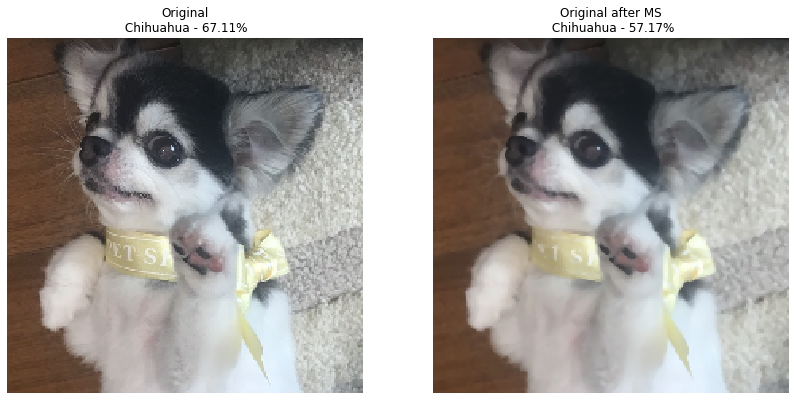

In [11]:
plt.figure(figsize=(14, 14))

# オリジナル画像を表示
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original\n {0} - {1:.2f}%'.format(original_name, original_score * 100))
plt.imshow(original_image/255.0)

# Median Smoothing 適用後のオリジナル画像を表示
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Original after MS\n {0} - {1:.2f}%'.format(original_ms_name, original_ms_score * 100))
plt.imshow(original_ms_image/255.0)

## Median Smoothing 適用前後の「敵対的サンプル」の表示

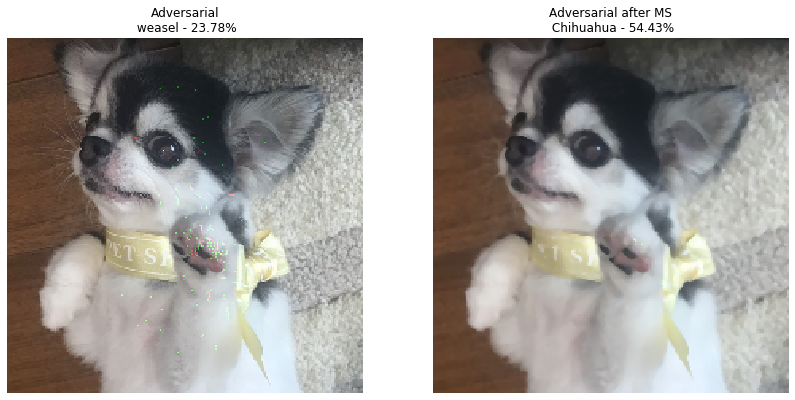

In [84]:
plt.figure(figsize=(14, 14))

# 敵対的サンプルを表示
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Adversarial\n {0} - {1:.2f}%'.format(adv_name, adv_score * 100))
plt.imshow(adv_image/255.0)

# Median Smoothing 適用後の敵対的サンプルを表示
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Adversarial after MS\n {0} - {1:.2f}%'.format(adv_ms_name, adv_ms_score * 100))
plt.imshow(adv_ms_image/255.0)

# 3. 攻撃検知のイメージ

## 攻撃検知用の関数

In [ ]:
def anomaly_detection(non_preprocess_class, preprocessed_class):
    if non_preprocess_class == preprocessed_class:
        print('Normal.')
    else:
        print('Anomaly.')

## 正常ケース

In [78]:
anomaly_detection(original_class, original_ms_class)

Normal.


## 異常ケース

In [80]:
anomaly_detection(adv_class, adv_ms_class)

Anomaly.
